# Write/read SIDpy Dataset via pyNSID

*Author: Maxim Ziatdinov*

*Date: September 2020*

update: 
- *Gerd Duscher 01/2021 (compatibility to pyNSID version 0.0.2)*

A fast introduction into how to write SIDpy datasets to NSID formatted HDF5 files

Start with standard imports:

In [7]:
import warnings

import h5py
import matplotlib.pylab as plt
import numpy as np


# we will also need a sidpy package
import sys
sys.path.insert(0, '../../')
import pyNSID
print(pyNSID.__version__)

import sidpy
import SciFiReaders


warnings.filterwarnings("ignore", module="numpy.core.fromnumeric")
warnings.filterwarnings("ignore", module="pyNSID.io.nsi_reader")

0.0.4g


## Creating sidpy.Dataset object(s)

Let's create a simple sidpy Dataset from a numpy array:

In [8]:
dataset = sidpy.Dataset.from_array(np.random.random([4, 5, 10]), name='new')
dataset

sidpy.Dataset of type UNKNOWN with:
 dask.array<array, shape=(4, 5, 10), dtype=float64, chunksize=(4, 5, 10), chunktype=numpy.ndarray>
 data contains: generic (generic)
 and Dimensions: 
a:  generic (generic) of size (4,)
b:  generic (generic) of size (5,)
c:  generic (generic) of size (10,)

Let's also define the dataset attributes...

In [9]:
dataset.data_type = 'SPECTRAL_IMAGE'
dataset.units = 'nA'
dataset.quantity = 'Current'

... and set individual dimensions. In the case of spectroscopic datasets, the first two dimensions are typically spatial units (e.g. nm) and the third one can be energy (e.g. $meV$ or $nm^{-1}$).

In [10]:
dataset.set_dimension(0, sidpy.Dimension(np.arange(dataset.shape[0]), 'x',
                                        units='nm', quantity='Length',
                                        dimension_type='spatial'))
dataset.set_dimension(1, sidpy.Dimension(np.linspace(-2, 2, num=dataset.shape[1], endpoint=True), 'y', 
                                        units='nm', quantity='Length',
                                        dimension_type='spatial'))
dataset.set_dimension(2, sidpy.Dimension(np.sin(np.linspace(0, 2 * np.pi, num=dataset.shape[2])), 'bias',
                                        units='mV', quantity='Voltage',
                                        dimension_type='spectral'))

In [11]:
print(dataset.dim_0)
print(dataset.dim_1)
print(dataset.dim_2)

x:  Length (nm) of size (4,)
y:  Length (nm) of size (5,)
bias:  Voltage (mV) of size (10,)


Let's add some structures to the dataset

In [13]:
import ase.build
atoms = ase.build.bulk('Al', 'fcc', a=4.05, cubic=True)
dataset.structures.update({'Al': atoms})
atoms = ase.build.bulk('Cu', 'fcc', a=3.60, cubic=True)
dataset.structures.update({'Cu': atoms})

## Writing sidpy.Dataset object(s) to HDF5 files

Write NSID-formatted h5 file:

In [14]:
hf = h5py.File("test.hf5", 'a')

Let's create a new channel where we are going to save our sidpy dataset:

In [15]:
hf.create_group('Measurement_000/Channel_000')
print(*hf["Measurement_000"].keys())

Channel_000


Now let's write our sidpy dataset into the newly created channel:

In [16]:
pyNSID.hdf_io.write_nsid_dataset(dataset, hf['Measurement_000/Channel_000'], main_data_name="new_spectrum");

/mnt/c/Users/gduscher/Documents/Github/pyNSID/notebooks/00_basic_usage/../../pyNSID/io/hdf_utils.py:370: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


Close h5 file:

In [17]:
hf.close()

## Reading sidpy.Dataset object(s)

Load back the file:

In [18]:
hf = h5py.File("test.hf5", 'r+')
print(*hf["Measurement_000"].keys())

Channel_000


In [19]:
sidpy.hdf_utils.print_tree(hf, rel_paths=False)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ new_spectrum
      ------------
      ├ Structure_000
        -------------
        ├ Al
          --
          ├ info
            ----
      ├ Structure_001
        -------------
        ├ Cu
          --
          ├ info
            ----
      ├ bias
      ├ new_spectrum
      ├ x
      ├ y


Find our dataset:

In [20]:
dataset_hdf5  =  pyNSID.io.hdf_utils.find_dataset(hf,'new_spectrum')[0]
dataset_hdf5

<HDF5 dataset "new_spectrum": shape (4, 5, 10), type "<f8">

In [22]:
hf.close()

Read the dataset stored in HDF5 format as a sidpy object (Dataset) using NSIDReader:

0 DimensionType.SPATIAL
1 DimensionType.SPATIAL
2 DimensionType.SPECTRAL


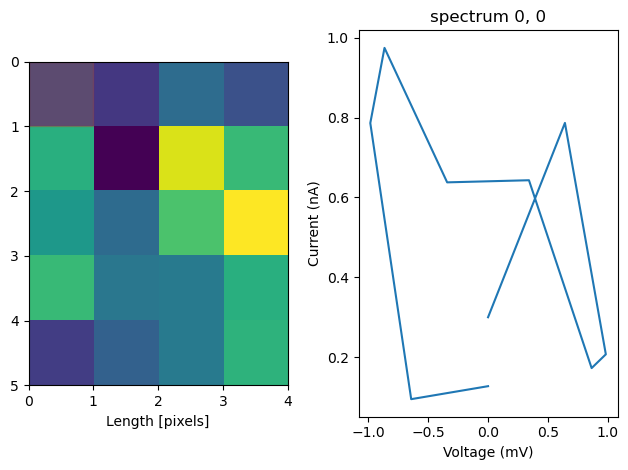

In [23]:
reader = SciFiReaders.NSIDReader('test.hf5')
dataset_sid = reader.read()[0]
assert isinstance(dataset_sid, sidpy.Dataset)
view = dataset_sid.plot()

In [26]:
print(dataset_sid)
print(dataset_sid.structures)
dataset_sid

sidpy.Dataset of type SPECTRAL_IMAGE with:
 dask.array<array, shape=(4, 5, 10), dtype=float64, chunksize=(4, 5, 10), chunktype=numpy.ndarray>
 data contains: Current (nA)
 and Dimensions: 
x:  Length (nm) of size (4,)
y:  Length (nm) of size (5,)
bias:  Voltage (mV) of size (10,)
{'Al': Atoms(symbols='Al4', pbc=False, cell=[4.05, 4.05, 4.05]), 'Cu': Atoms(symbols='Cu4', pbc=False, cell=[3.6, 3.6, 3.6])}


sidpy.Dataset of type SPECTRAL_IMAGE with:
 dask.array<array, shape=(4, 5, 10), dtype=float64, chunksize=(4, 5, 10), chunktype=numpy.ndarray>
 data contains: Current (nA)
 and Dimensions: 
x:  Length (nm) of size (4,)
y:  Length (nm) of size (5,)
bias:  Voltage (mV) of size (10,)

## Close File

In [27]:
dataset_sid.h5_dataset.file.close()